In [ ]:
G# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from skimage import feature, io, color, exposure
from scipy import ndimage, stats
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import glob
from tqdm.notebook import tqdm

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# Define dataset paths
first_prints_path = '/content/drive/MyDrive/qrproject/first_prints'
second_prints_path = '/content/drive/MyDrive/qrproject/second_prints'

# Get file lists
first_print_files = glob.glob(os.path.join(first_prints_path, '*.jpg')) + glob.glob(os.path.join(first_prints_path, '*.png'))
second_print_files = glob.glob(os.path.join(second_prints_path, '*.jpg')) + glob.glob(os.path.join(second_prints_path, '*.png'))

# Report dataset statistics
print(f"Total number of first print (original) images: {len(first_print_files)}")
print(f"Total number of second print (counterfeit) images: {len(second_print_files)}")
print(f"Total dataset size: {len(first_print_files) + len(second_print_files)} images")

Total number of first print (original) images: 100
Total number of second print (counterfeit) images: 100
Total dataset size: 200 images


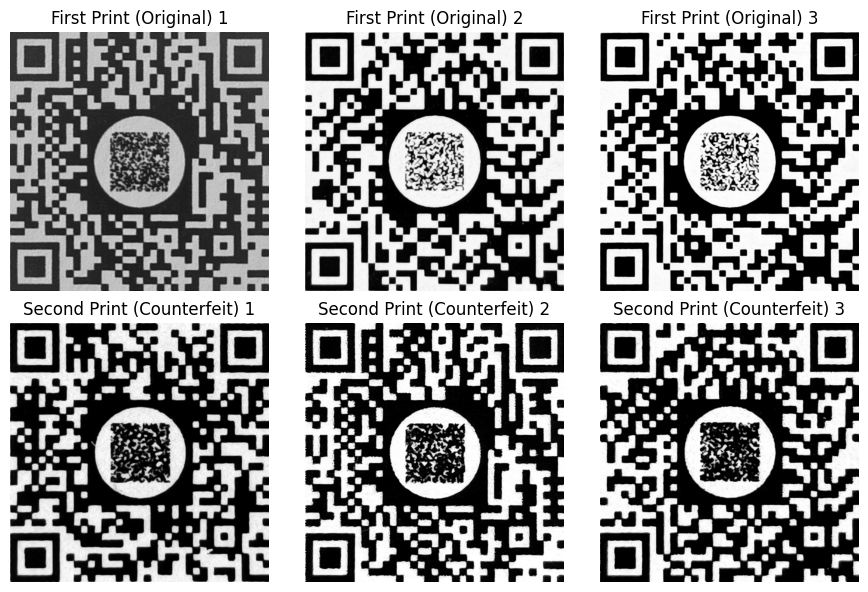

In [6]:
def display_sample_images(first_print_files, second_print_files, num_samples=3):
    """Display sample images from both classes side by side"""
    plt.figure(figsize=(9, 6))

    # Select random samples
    first_samples = random.sample(first_print_files, num_samples)
    second_samples = random.sample(second_print_files, num_samples)

    # Display first prints (originals)
    for i, img_path in enumerate(first_samples):
        img = Image.open(img_path)
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"First Print (Original) {i+1}")
        plt.axis('off')

    # Display second prints (counterfeits)
    for i, img_path in enumerate(second_samples):
        img = Image.open(img_path)
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(img)
        plt.title(f"Second Print (Counterfeit) {i+1}")

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(first_print_files, second_print_files)

In [7]:
def analyze_image_properties(file_list, label):
    """Analyze and return properties of images in the given file list"""
    dimensions = []
    aspect_ratios = []
    file_sizes = []
    color_modes = []

    for file_path in tqdm(file_list[:100], desc=f"Analyzing {label} images"):  # Limiting to 100 for speed
        # Get file size
        file_sizes.append(os.path.getsize(file_path) / 1024)  # Size in KB

        # Get image dimensions
        img = Image.open(file_path)
        width, height = img.size
        dimensions.append((width, height))
        aspect_ratios.append(width / height)

        # Check color mode
        mode = img.mode
        color_modes.append(mode)

    return {
        'dimensions': dimensions,
        'aspect_ratios': aspect_ratios,
        'file_sizes': file_sizes,
        'color_modes': color_modes
    }

# Analyze properties of both classes
first_print_properties = analyze_image_properties(first_print_files, "first print")
second_print_properties = analyze_image_properties(second_print_files, "second print")

# Report image property statistics
print("\nImage Property Statistics:")
print("\nFirst Prints (Originals):")
print(f"Dimensions: Most common is {pd.Series([f'{w}x{h}' for w, h in first_print_properties['dimensions']]).value_counts().index[0]}")
print(f"Color modes: {pd.Series(first_print_properties['color_modes']).value_counts().to_dict()}")
print(f"Average file size: {np.mean(first_print_properties['file_sizes']):.2f} KB")

print("\nSecond Prints (Counterfeits):")
print(f"Dimensions: Most common is {pd.Series([f'{w}x{h}' for w, h in second_print_properties['dimensions']]).value_counts().index[0]}")
print(f"Color modes: {pd.Series(second_print_properties['color_modes']).value_counts().to_dict()}")
print(f"Average file size: {np.mean(second_print_properties['file_sizes']):.2f} KB")

Analyzing first print images:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing second print images:   0%|          | 0/100 [00:00<?, ?it/s]


Image Property Statistics:

First Prints (Originals):
Dimensions: Most common is 815x815
Color modes: {'RGBA': 100}
Average file size: 531.97 KB

Second Prints (Counterfeits):
Dimensions: Most common is 899x899
Color modes: {'RGBA': 100}
Average file size: 582.34 KB


In [8]:
def analyze_visual_features(first_print_path, second_print_path):
    """Extract and compare visual features between original and counterfeit images"""
    # Load images
    first_img = cv2.imread(first_print_path)
    second_img = cv2.imread(second_print_path)

    # Check if images were loaded successfully
    if first_img is None or second_img is None:
        print(f"Error loading images:\n{first_print_path}\n{second_print_path}")
        return None, None, None, None, None, None, None

    # Resize to a common size for comparison
    target_size = (400, 400)  # You can adjust this as needed
    first_img = cv2.resize(first_img, target_size)
    second_img = cv2.resize(second_img, target_size)

    # Convert to grayscale
    first_gray = cv2.cvtColor(first_img, cv2.COLOR_BGR2GRAY)
    second_gray = cv2.cvtColor(second_img, cv2.COLOR_BGR2GRAY)

    # Calculate features
    features = {}

    # 1. Histogram comparison
    hist1 = cv2.calcHist([first_gray], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([second_gray], [0], None, [256], [0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()
    features['histogram_correlation'] = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

    # 2. SSIM (Structural Similarity Index)
    from skimage.metrics import structural_similarity as ssim
    features['ssim'] = ssim(first_gray, second_gray)

    # 3. Edge detection and comparison
    edges1 = cv2.Canny(first_gray, 100, 200)
    edges2 = cv2.Canny(second_gray, 100, 200)
    features['edge_difference'] = np.sum(cv2.absdiff(edges1, edges2)) / (edges1.shape[0] * edges1.shape[1])

    # 4. Local Binary Patterns for texture analysis
    radius = 3
    n_points = 8 * radius
    lbp1 = feature.local_binary_pattern(first_gray, n_points, radius, method='uniform')
    lbp2 = feature.local_binary_pattern(second_gray, n_points, radius, method='uniform')
    features['lbp_difference'] = np.sum(np.abs(lbp1 - lbp2)) / (lbp1.shape[0] * lbp1.shape[1])

    return features, first_img, second_img, edges1, edges2, first_gray, second_gray

def visualize_differences(sample_pairs=5):
    """Visualize key differences between original and counterfeit samples"""
    # Randomly select sample pairs
    first_samples = random.sample(first_print_files, sample_pairs)
    second_samples = random.sample(second_print_files, sample_pairs)

    all_features = []

    for i in range(min(sample_pairs, 3)):  # Limit visual output to 3 pairs
        features, first_img, second_img, edges1, edges2, first_gray, second_gray = analyze_visual_features(first_samples[i], second_samples[i])

        # Skip this pair if there was an error loading the images
        if features is None:
            continue

        all_features.append(features)

        # Compute absolute difference between images
        diff_img = cv2.absdiff(first_gray, second_gray)
        # Enhance differences for better visualization
        diff_img_enhanced = exposure.adjust_gamma(diff_img, 2)

        # Visualize
        plt.figure(figsize=(20, 10))

        plt.subplot(2, 4, 1)
        plt.imshow(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB))
        plt.title("Original QR Code")
        plt.axis('off')

        plt.subplot(2, 4, 2)
        plt.imshow(cv2.cvtColor(second_img, cv2.COLOR_BGR2RGB))
        plt.title("Counterfeit QR Code")
        plt.axis('off')

        plt.subplot(2, 4, 3)
        plt.imshow(diff_img, cmap='hot')
        plt.title("Absolute Difference")
        plt.axis('off')

        plt.subplot(2, 4, 4)
        plt.imshow(diff_img_enhanced, cmap='hot')
        plt.title("Enhanced Difference")
        plt.axis('off')

        plt.subplot(2, 4, 5)
        plt.imshow(edges1, cmap='gray')
        plt.title("Original Edges")
        plt.axis('off')

        plt.subplot(2, 4, 6)
        plt.imshow(edges2, cmap='gray')
        plt.title("Counterfeit Edges")
        plt.axis('off')

        plt.subplot(2, 4, 7)
        plt.hist(first_gray.ravel(), 256, [0, 256], alpha=0.7, label='Original')
        plt.hist(second_gray.ravel(), 256, [0, 256], alpha=0.7, label='Counterfeit')
        plt.title("Grayscale Histograms")
        plt.legend()

        plt.subplot(2, 4, 8)
        plt.bar(['Hist Corr', 'SSIM', 'Edge Diff', 'LBP Diff'],
                [features['histogram_correlation'], features['ssim'],
                 features['edge_difference'], features['lbp_difference']])
        plt.title("Similarity Metrics")
        plt.ylim(0, 1)

        plt.tight_layout()
        plt.show()

        print(f"Sample {i+1} Metrics:")
        print(f"Histogram Correlation: {features['histogram_correlation']:.4f} (higher = more similar)")
        print(f"SSIM: {features['ssim']:.4f} (higher = more similar)")
        print(f"Edge Difference: {features['edge_difference']:.4f} (lower = more similar)")
        print(f"LBP Texture Difference: {features['lbp_difference']:.4f} (lower = more similar)")
        print("\n")

    # Compile feature statistics across all samples
    if len(all_features) > 0:
        df_features = pd.DataFrame(all_features)
        print("Statistical summary of features across all samples:")
        print(df_features.describe())

        # Visualize feature distributions
        plt.figure(figsize=(15, 5))
        for i, col in enumerate(df_features.columns):
            plt.subplot(1, 4, i+1)
            sns.histplot(df_features[col], kde=True)
            plt.title(col)
        plt.tight_layout()
        plt.show()

# Analyze and visualize differences between original and counterfeit QR codes
visualize_differences()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
def analyze_frequency_domain(num_samples=3):
    """Analyze images in frequency domain to detect subtle differences"""
    # Randomly select samples
    first_samples = random.sample(first_print_files, num_samples)
    second_samples = random.sample(second_print_files, num_samples)

    for i in range(num_samples):
        # Load images
        first_img = cv2.imread(first_samples[i], 0)  # Grayscale
        second_img = cv2.imread(second_samples[i], 0)  # Grayscale

        # Skip if any image failed to load
        if first_img is None or second_img is None:
            print(f"Error loading images, skipping pair {i+1}")
            continue

        # Resize to common dimensions
        target_size = (400, 400)
        first_img = cv2.resize(first_img, target_size)
        second_img = cv2.resize(second_img, target_size)

        # Compute FFT
        f1 = np.fft.fft2(first_img)
        f1_shift = np.fft.fftshift(f1)
        f1_mag = np.log(np.abs(f1_shift) + 1)

        f2 = np.fft.fft2(second_img)
        f2_shift = np.fft.fftshift(f2)
        f2_mag = np.log(np.abs(f2_shift) + 1)

        # Compute difference in frequency domain
        f_diff = np.abs(f1_shift - f2_shift)
        f_diff_mag = np.log(f_diff + 1)

        # Visualize
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 5, 1)
        plt.imshow(first_img, cmap='gray')
        plt.title("Original QR")
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(second_img, cmap='gray')
        plt.title("Counterfeit QR")
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(f1_mag, cmap='viridis')
        plt.title("Original Frequency")
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(f2_mag, cmap='viridis')
        plt.title("Counterfeit Frequency")
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(f_diff_mag, cmap='hot')
        plt.title("Frequency Difference")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Analyze frequency domain characteristics
analyze_frequency_domain()

Output hidden; open in https://colab.research.google.com to view.

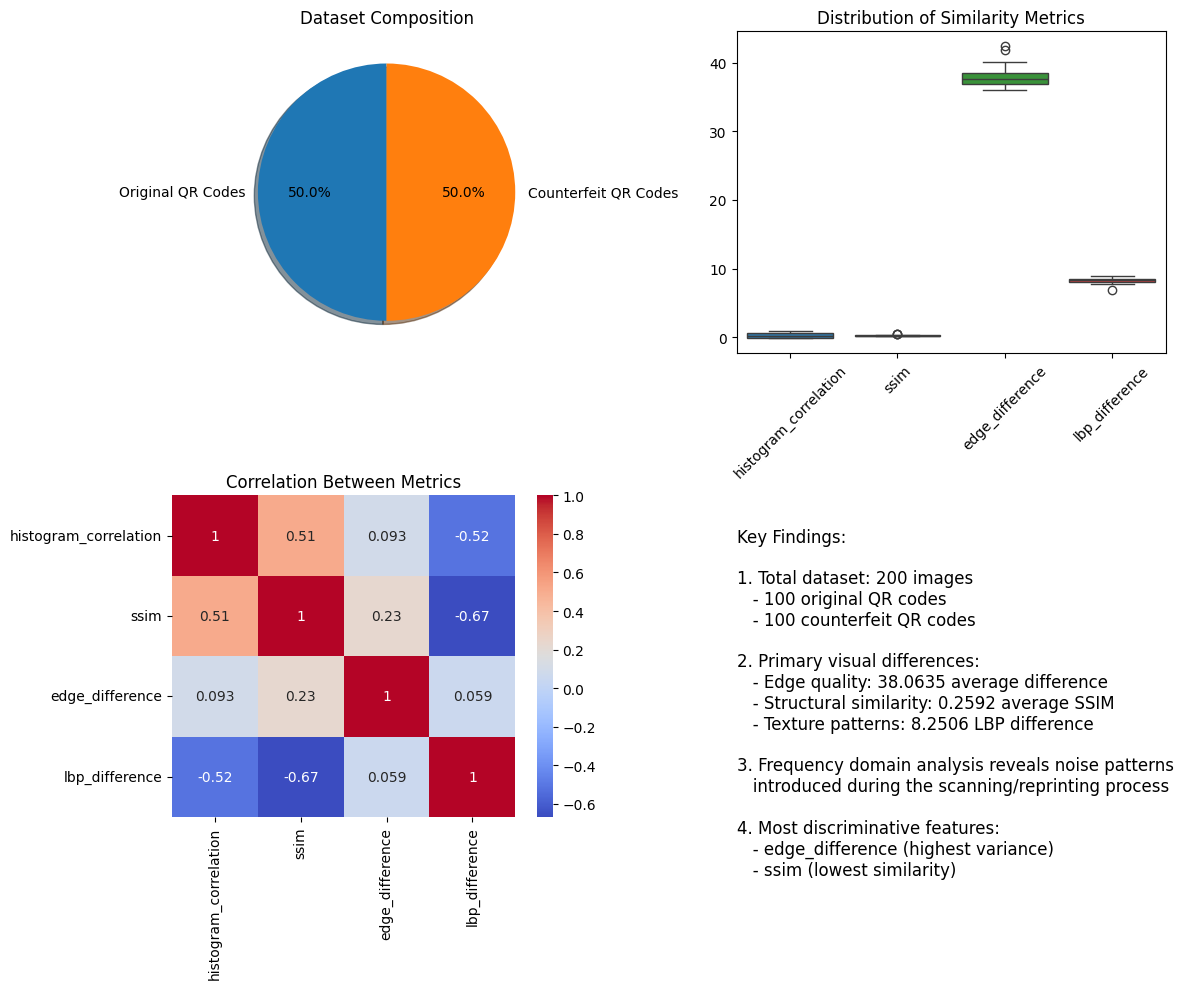


=== DATASET ANALYSIS SUMMARY ===
Total images: 200
Class distribution: 100 originals, 100 counterfeits

Key visual differences between original and counterfeit QR codes:
1. Histogram correlation: 0.2688 ± 0.3560
2. Structural similarity: 0.2592 ± 0.1025
3. Edge differences: 38.0635 ± 1.6955
4. Texture differences: 8.2506 ± 0.4714

Recommended features for classification:
- histogram_correlation: Medium discriminative power
- ssim: Medium discriminative power
- edge_difference: High discriminative power
- lbp_difference: Medium discriminative power


In [10]:
def summarize_findings():
    """Summarize key findings from our analysis"""
    # Calculate average features from a larger sample
    num_analysis_samples = 20
    first_samples = random.sample(first_print_files, min(num_analysis_samples, len(first_print_files)))
    second_samples = random.sample(second_print_files, min(num_analysis_samples, len(second_print_files)))

    all_features = []
    for i in range(len(first_samples)):
        features, _, _, _, _, _, _ = analyze_visual_features(first_samples[i], second_samples[i])
        if features is not None:
            all_features.append(features)

    # Check if we have collected any valid features
    if not all_features:
        print("Error: Could not collect any valid feature comparisons between images.")
        return

    df_features = pd.DataFrame(all_features)

    # Display summary statistics
    plt.figure(figsize=(12, 10))

    # Dataset composition
    plt.subplot(2, 2, 1)
    plt.pie([len(first_print_files), len(second_print_files)],
            labels=['Original QR Codes', 'Counterfeit QR Codes'],
            autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('Dataset Composition')

    # Feature distributions
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df_features)
    plt.title('Distribution of Similarity Metrics')
    plt.xticks(rotation=45)

    # Correlation matrix
    plt.subplot(2, 2, 3)
    sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Between Metrics')

    # Summary findings
    plt.subplot(2, 2, 4)
    plt.axis('off')
    summary_text = (
        "Key Findings:\n\n"
        f"1. Total dataset: {len(first_print_files) + len(second_print_files)} images\n"
        f"   - {len(first_print_files)} original QR codes\n"
        f"   - {len(second_print_files)} counterfeit QR codes\n\n"
        f"2. Primary visual differences:\n"
        f"   - Edge quality: {df_features['edge_difference'].mean():.4f} average difference\n"
        f"   - Structural similarity: {df_features['ssim'].mean():.4f} average SSIM\n"
        f"   - Texture patterns: {df_features['lbp_difference'].mean():.4f} LBP difference\n\n"
        f"3. Frequency domain analysis reveals noise patterns\n"
        f"   introduced during the scanning/reprinting process\n\n"
        f"4. Most discriminative features:\n"
        f"   - {df_features.std().idxmax()} (highest variance)\n"
        f"   - {df_features.mean().idxmin()} (lowest similarity)"
    )
    plt.text(0, 0.9, summary_text, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()

    # Print textual summary
    print("\n=== DATASET ANALYSIS SUMMARY ===")
    print(f"Total images: {len(first_print_files) + len(second_print_files)}")
    print(f"Class distribution: {len(first_print_files)} originals, {len(second_print_files)} counterfeits")
    print("\nKey visual differences between original and counterfeit QR codes:")
    print(f"1. Histogram correlation: {df_features['histogram_correlation'].mean():.4f} ± {df_features['histogram_correlation'].std():.4f}")
    print(f"2. Structural similarity: {df_features['ssim'].mean():.4f} ± {df_features['ssim'].std():.4f}")
    print(f"3. Edge differences: {df_features['edge_difference'].mean():.4f} ± {df_features['edge_difference'].std():.4f}")
    print(f"4. Texture differences: {df_features['lbp_difference'].mean():.4f} ± {df_features['lbp_difference'].std():.4f}")
    print("\nRecommended features for classification:")
    for feature in df_features.columns:
        print(f"- {feature}: {'High' if df_features[feature].std() > df_features.std().mean() else 'Medium'} discriminative power")


# Generate summary of findings
summarize_findings()

In [11]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.9 MB/s eta 0:00:00


In [12]:
# Function to extract visual features
from skimage.feature import hog, local_binary_pattern
from scipy.fftpack import fft2, fftshift
from scipy.ndimage import variance
import pywt

def extract_visual_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Edge Density (Canny Edge Detection)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / edges.size

    # Histogram of Oriented Gradients (HOG)
    hog_features, _ = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog_mean = np.mean(hog_features)

    # Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist = np.histogram(lbp, bins=np.arange(0, 11), density=True)[0]

    # Variance of Laplacian (Blur Detection)
    blur_value = variance(cv2.Laplacian(gray, cv2.CV_64F))

    return edge_density, hog_mean, lbp_hist, blur_value

# Function to extract frequency domain features
def extract_frequency_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # FFT and Power Spectrum
    f_transform = fftshift(fft2(gray))
    power_spectrum = np.abs(f_transform) ** 2
    power_mean = np.mean(power_spectrum)

    # Wavelet Transform (DWT)
    coeffs2 = pywt.dwt2(gray, 'haar')
    cA, (cH, cV, cD) = coeffs2
    wavelet_energy = np.sum(np.abs(cA))

    return power_mean, wavelet_energy

In [13]:
    #import cv2
    #import numpy as np
    #import pandas as pd
   # import pywt
   # from skimage.feature import hog, local_binary_pattern
    #from scipy.fftpack import fft2, fftshift
    #from scipy.ndimage import variance
#    import os
#
#
 #   # Function to process a folder of images
  #  def process_folder(folder_path, label):
   #     data = []
    #    for filename in os.listdir(folder_path):
#            img_path = os.path.join(folder_path, filename)
#            image = cv2.imread(img_path)
#            if image is None:
#                continue
#
#            # Extract features
#            edge_density, hog_mean, lbp_hist, blur_value = extract_visual_features(image)
#            power_mean, wavelet_energy = extract_frequency_features(image)
#
#            # Flatten LBP histogram and store features
#            features = [edge_density, hog_mean, blur_value, power_mean, wavelet_energy] + lbp_hist.tolist()
#            data.append([filename] + features + [label])

#        return data


    # Paths to datasets
#    first_prints_folder = "/content/drive/MyDrive/qrproject/first_prints"
#    second_prints_folder = "/content/drive/MyDrive/qrproject/second_prints"

    # Process images
#   original_data = process_folder(first_prints_folder, 0)
#    counterfeit_data = process_folder(second_prints_folder, 1)

    # Create DataFrame
#    columns = ["filename", "edge_density", "hog_mean", "blur_value", "power_mean", "wavelet_energy"] + [f"lbp_{i}" for i in range(10)] + ["label"]
#    df = pd.DataFrame(original_data + counterfeit_data, columns=columns)

    # Save features
#    df.to_csv("qr_features.csv", index=False)
#    print("Feature extraction complete. Data saved to qr_features.csv")


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "/content/drive/MyDrive/qrproject/models/traditional_QR/qr_features.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Display basic info and first few rows
print("Dataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        200 non-null    object 
 1   edge_density    200 non-null    float64
 2   hog_mean        200 non-null    float64
 3   blur_value      200 non-null    float64
 4   power_mean      200 non-null    float64
 5   wavelet_energy  200 non-null    float64
 6   lbp_0           200 non-null    float64
 7   lbp_1           200 non-null    float64
 8   lbp_2           200 non-null    float64
 9   lbp_3           200 non-null    float64
 10  lbp_4           200 non-null    float64
 11  lbp_5           200 non-null    float64
 12  lbp_6           200 non-null    float64
 13  lbp_7           200 non-null    float64
 14  lbp_8           200 non-null    float64
 15  lbp_9           200 non-null    float64
 16  label           200 non-null    int64  
dtypes: float64(15), int64

In [15]:
print("\nFirst Few Rows:")
print(df.head())



First Few Rows:
                     filename  edge_density  hog_mean  blur_value  \
0  input_image_degree (2).png     12.395559  0.099650  275.078267   
1  input_image_candle (2).png     13.627785  0.102073  387.079674   
2  input_image_bottle (2).png     13.254650  0.103505  309.165244   
3  input_image_decade (2).png     13.700315  0.100611  374.605493   
4  input_image_crutch (2).png     13.841123  0.097868  548.618994   

     power_mean  wavelet_energy     lbp_0     lbp_1     lbp_2     lbp_3  \
0  1.272019e+10      33686203.5  0.013887  0.043670  0.025567  0.122017   
1  9.953546e+09      27394138.0  0.015060  0.045394  0.031560  0.129454   
2  1.203157e+10      33200564.0  0.015119  0.045518  0.031105  0.127058   
3  1.066921e+10      29078015.5  0.014763  0.044858  0.029366  0.127560   
4  9.341806e+09      24683492.5  0.015037  0.046193  0.032192  0.125554   

      lbp_4     lbp_5     lbp_6     lbp_7     lbp_8     lbp_9  label  
0  0.267414  0.213714  0.075720  0.055444  0.1

In [16]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
filename          0
edge_density      0
hog_mean          0
blur_value        0
power_mean        0
wavelet_energy    0
lbp_0             0
lbp_1             0
lbp_2             0
lbp_3             0
lbp_4             0
lbp_5             0
lbp_6             0
lbp_7             0
lbp_8             0
lbp_9             0
label             0
dtype: int64


In [17]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       edge_density    hog_mean  blur_value    power_mean  wavelet_energy  \
count    200.000000  200.000000  200.000000  2.000000e+02    2.000000e+02   
mean      12.975439    0.099163  296.311660  1.608020e+10    3.929005e+07   
std        1.718780    0.013005  140.154875  5.243196e+09    9.228158e+06   
min       10.305747    0.074789   31.915233  8.280353e+09    2.285158e+07   
25%       11.707709    0.088797  231.528743  1.095758e+10    3.098299e+07   
50%       12.593256    0.100152  300.953264  1.559331e+10    3.936769e+07   
75%       13.805494    0.108008  369.723845  2.020337e+10    4.615395e+07   
max       21.236491    0.125800  666.646374  2.852831e+10    6.388760e+07   

            lbp_0       lbp_1       lbp_2       lbp_3       lbp_4       lbp_5  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.011895    0.035825    0.020513    0.120256    0.266015    0.208417   
std      0.003481    0.006700    0.011001 

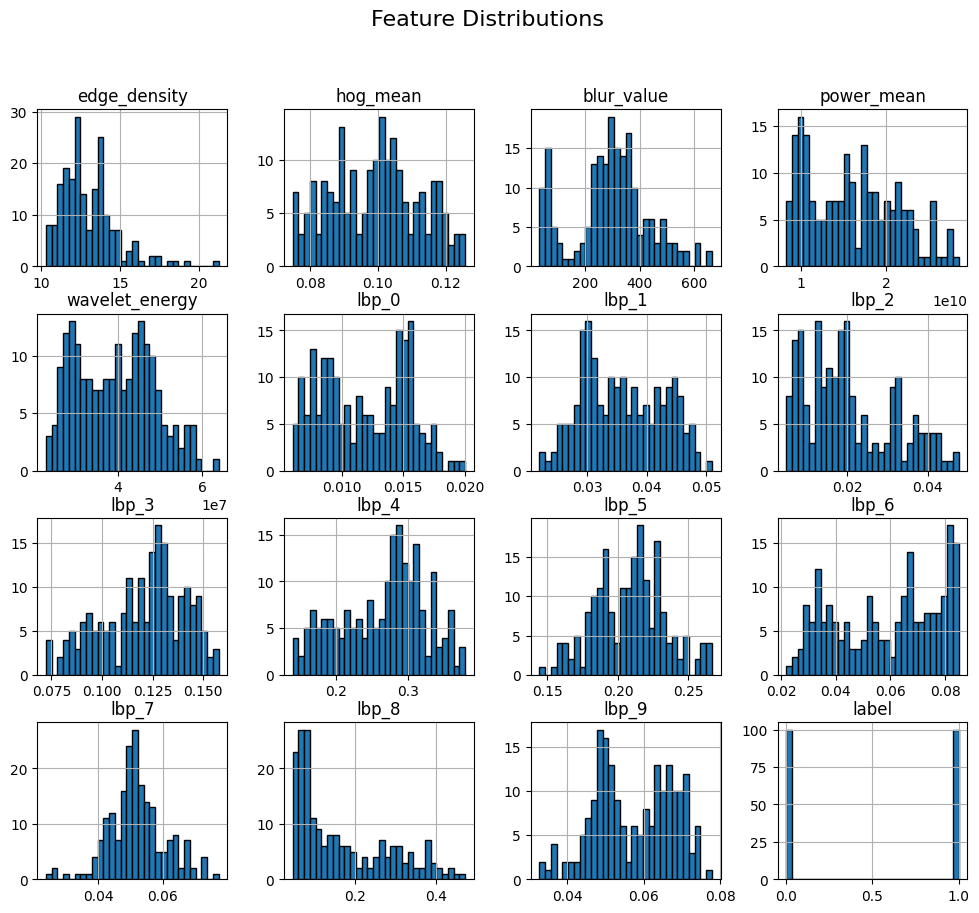

In [18]:
# Plot histograms for numerical features
df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

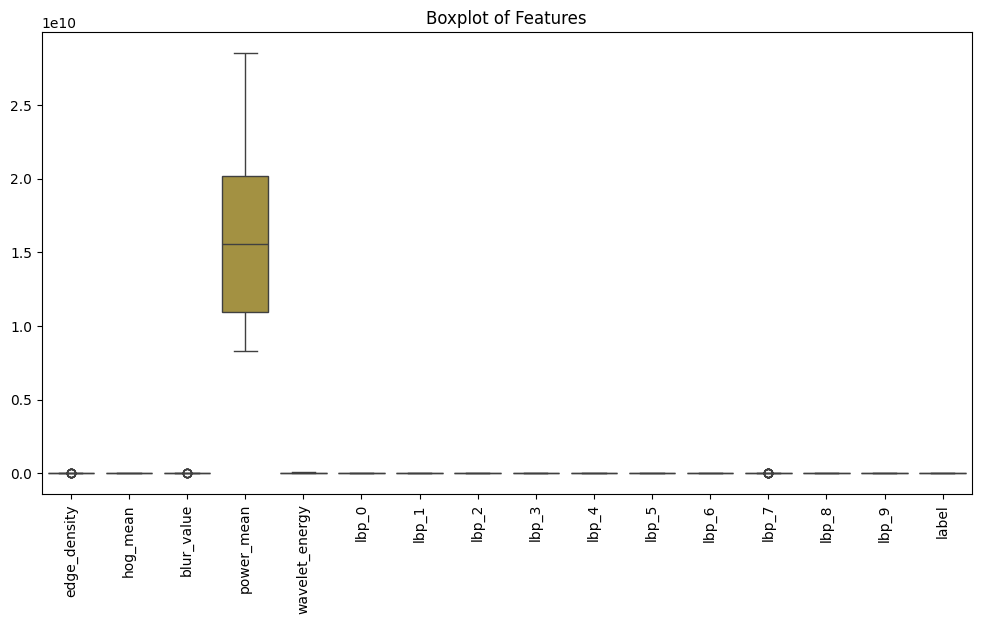

In [19]:
# Boxplots to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot of Features")
plt.show()

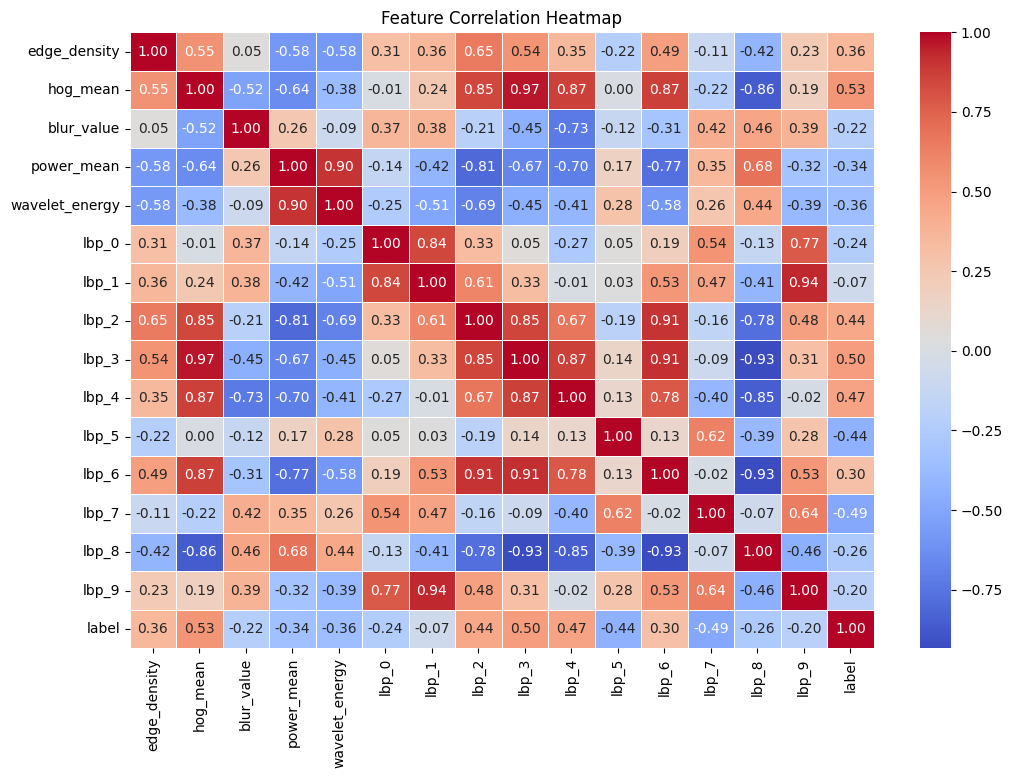

In [20]:
# Remove non-numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = df_numeric.corr()
# Heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Class Distribution:
label
0    100
1    100
Name: count, dtype: int64


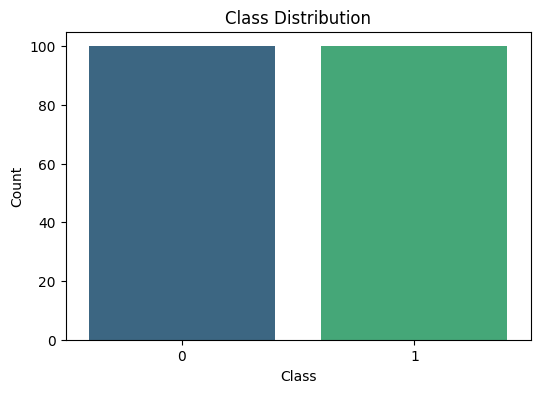

In [21]:
# Check class distribution
if 'label' in df.columns:  # Assuming the dataset has a column 'label' with class info
    print("\nClass Distribution:")
    print(df['label'].value_counts())

    # Visualize class distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df['label'], palette='viridis')
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()
else:
    print("\nWarning: No 'label' column found in dataset for class distribution analysis.")


In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "/content/drive/MyDrive/qrproject/models/traditional_QR/qr_features.csv"
df = pd.read_csv(file_path)

# Drop unnecessary categorical feature
df.drop(columns=['filename'], inplace=True, errors='ignore')

# Separate features and target variable
X = df.drop(columns=['label'])
y = df['label']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    }

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_results = evaluate_model(rf_model, X_test, y_test)
print("Random Forest Results:", rf_results)

# Support Vector Machine Model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)
svm_results = evaluate_model(svm_model, X_test, y_test)
print("SVM Results:", svm_results)

# K-Nearest Neighbors Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_results = evaluate_model(knn_model, X_test, y_test)
print("KNN Results:", knn_results)

# Determine best model
model_results = {"Random Forest": rf_results, "SVM": svm_results, "KNN": knn_results}
best_model = max(model_results, key=lambda x: model_results[x]['F1-Score'])
print(f"Best Model: {best_model} with F1-Score: {model_results[best_model]['F1-Score']}")


Random Forest Results: {'Accuracy': 0.95, 'Precision': 0.9545454545454545, 'Recall': 0.95, 'F1-Score': 0.949874686716792}
SVM Results: {'Accuracy': 0.95, 'Precision': 0.95, 'Recall': 0.95, 'F1-Score': 0.95}
KNN Results: {'Accuracy': 0.975, 'Precision': 0.9761904761904763, 'Recall': 0.975, 'F1-Score': 0.9749843652282676}
Best Model: KNN with F1-Score: 0.9749843652282676


In [24]:
import joblib
joblib.dump(knn_model,'knn_model')
joblib.dump(scaler,'qr_scaler')

['qr_scaler']

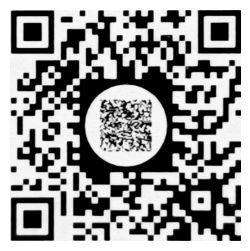

Prediction: Original QR Code


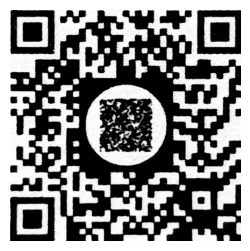

Prediction: Counterfeit QR Code


In [25]:
import cv2
import numpy as np
import joblib

# Load the trained KNN model and scaler
knn_model = joblib.load("/content/drive/MyDrive/qrproject/models/traditional_QR/knn_model")  # Update path if needed
scaler = joblib.load("/content/drive/MyDrive/qrproject/models/traditional_QR/qr_scaler")  # Update path if needed

def preprocess_single_image(image_path):
    """Extracts features from a single image and reshapes them for model prediction."""
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Error: Could not load image from {image_path}. Check if the path is correct.")

    # Extract visual features
    edge_density, hog_mean, lbp_hist, blur_value = extract_visual_features(image)
    # Extract frequency features
    power_mean, wavelet_energy = extract_frequency_features(image)

    # Flatten LBP histogram and combine all features into a single list
    features = [edge_density, hog_mean, blur_value, power_mean, wavelet_energy] + lbp_hist.tolist()

    # Convert to numpy array and reshape for model input
    features = np.array(features).reshape(1, -1)
    # Ensure features are real-valued before scaling
    features = features.astype(float)
    # Scale the features using the loaded scaler
    features_scaled = scaler.transform(features)

    return features_scaled

# Example usage
image_path_0 = "/content/drive/MyDrive/qrproject/models/traditional_QR/test_0.png"  # Update this path
image_path_1 = "/content/drive/MyDrive/qrproject/models/traditional_QR/test_1.png"  # Update this path

#features scaling
features_scaled_0 = preprocess_single_image(image_path_0)
features_scaled_1 = preprocess_single_image(image_path_1)

#plot image 1
plt.figure(figsize=(3,3))
img = Image.open(image_path_0)
plt.imshow(img)
plt.axis('off')
plt.show()
# Predict using the trained KNN model
prediction1 = knn_model.predict(features_scaled_0)
result1 = "Original QR Code" if prediction1[0] == 0 else "Counterfeit QR Code"
print("Prediction:", result1)

#plot image 2
plt.figure(figsize=(3,3))
img = Image.open(image_path_1)
plt.imshow(img)
plt.axis('off')
plt.show()
prediction2 = knn_model.predict(features_scaled_1)
result2 = "Original QR Code" if prediction2[0] == 0 else "Counterfeit QR Code"
print("Prediction:", result2)